In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import glob
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
data = []
labels = []

# 拿到数据路径，方便后续读取
dir_path = 'D:\\Desktop\\Python\\Signal_reconstruction\\Numerical_simulation_Data\\test'
# 获取目录及其子目录下所有CSV文件的路径
dataPaths = sorted(glob.glob(os.path.join(dir_path, '**', '*.csv'), recursive=True))
random.seed(42)
random.shuffle(dataPaths)

# 遍历读取数据
for dataPath in dataPaths:
    # 读取数据
    data_1 = pd.read_csv(dataPath)
    data.append(data_1.iloc[1:10001, 1])

# 将数据和标签转换为numpy数组
test_data = np.array(data, dtype="float")
test_labels = np.array(data, dtype="float")

In [3]:
test_datas=test_data.reshape(-1,test_data.shape[1],1)
print(test_datas.shape)

(220, 10000, 1)


In [4]:
a=10

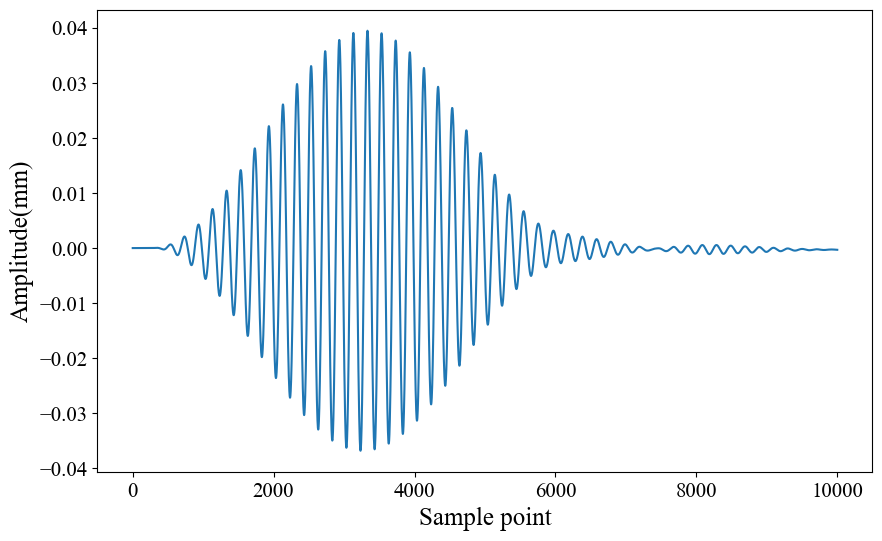

In [5]:
plt.style.use('default')
plt.figure(figsize=(10,6))
plt.rcParams['font.family'] = ['Times New Roman']
plt.plot(test_datas[a],linewidth=1.5)
plt.xlabel('Sample point',fontdict={'weight': 'normal', 'size': 18})
plt.ylabel('Amplitude(mm)',fontdict={'weight': 'normal', 'size': 18})
#坐标轴刻度大小设置
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('D:\\Desktop\\Python\\Signal_reconstruction\\Model\\PCA\\test_data.jpg', dpi=600, bbox_inches='tight')

In [6]:
def add_noise_with_snr(signal, snr_db):
    """
    根据信噪比（dB）为信号添加高斯噪声
    :param signal: 原始信号
    :param snr_db: 信噪比（dB）
    :return: 带噪声的信号
    """
    # 计算信号功率
    signal_power = np.mean(signal ** 2)
    
    # 将信噪比从分贝转换为线性比例
    snr_linear = 10 ** (snr_db / 10)
    
    # 计算噪声功率
    noise_power = signal_power / snr_linear
    
    # 生成高斯噪声
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    
    # 添加噪声
    noisy_signal = signal + noise
    return noisy_signal

In [7]:
def calculate_snr(x_prime, x):
    """
    计算信号的信噪比（SNR）。

    参数:
        x (numpy.ndarray): 干净信号。
        x_prime (numpy.ndarray): 噪声信号。

    返回:
        float: 信噪比，单位为 dB。
    """
    # 计算信号功率
    signal_power = np.mean(x ** 2)
    
    noise = x_prime-x
    # 计算噪声功率
    noise_power = np.mean(noise ** 2)
    
    # 计算信噪比
    if noise_power == 0:
        raise ValueError("噪声功率不能为零，这可能导致除以零的错误。")
    
    snr = 10 * np.log10(signal_power / noise_power)
    
    return snr  # 将结果转换为 Python 标量

In [8]:
def calculate_pcc(x, y):
    """
    计算两个信号的皮尔逊相关系数（PCC）。

    参数:
        x (torch.Tensor): 第一个信号，假定在 CUDA 上。
        y (torch.Tensor): 第二个信号，假定在 CUDA 上。

    返回:
        float: 皮尔逊相关系数。
    """
    
    # 计算均值
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    
    # 计算协方差
    covariance = np.mean((x - mean_x) * (y - mean_y))
    
    # 计算标准差
    std_x = np.std(x)
    std_y = np.std(y)
    
    # 计算皮尔逊相关系数
    if std_x == 0 or std_y == 0:
        raise ValueError("标准差不能为零，这可能导致除以零的错误。")
    
    pcc = covariance / (std_x * std_y)

    return pcc  # 将结果转换为 Python 标量


In [9]:
# 添加噪声，信噪比为20dB
snr_db = 20  # 信噪比（dB）
test_noisy_signal = add_noise_with_snr(test_datas, snr_db)
print(f'test_noisy_signal.shape:{test_noisy_signal.shape}')

test_noisy_signal.shape:(220, 10000, 1)


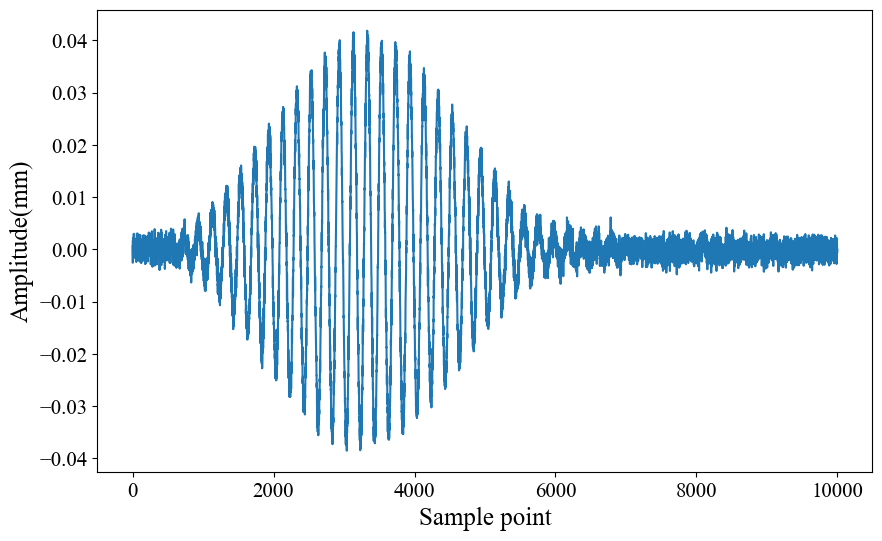

In [10]:
plt.style.use('default')
plt.figure(figsize=(10,6))
plt.rcParams['font.family'] = ['Times New Roman']
plt.plot(test_noisy_signal[a],linewidth=1.5)
plt.xlabel('Sample point',fontdict={'weight': 'normal', 'size': 18})
plt.ylabel('Amplitude(mm)',fontdict={'weight': 'normal', 'size': 18})
#坐标轴刻度大小设置
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('D:\\Desktop\\Python\\Signal_reconstruction\\Model\\PCA\\test_data_noise.jpg', dpi=600, bbox_inches='tight')

In [11]:
n = 8  # 压缩比

In [12]:
Original_signal = test_datas[a].flatten()
Test_signal = test_noisy_signal[a].flatten()

In [13]:
# 将信号分割成多个窗口（每段长度为 n）
segment_length = n  # 每个窗口的长度
num_segments = len(Test_signal) // segment_length  # 可以分割的窗口数量
Signal_segments = Test_signal[:num_segments * segment_length].reshape(-1, segment_length)

# 应用PCA进行降维和重构
pca = PCA(n_components=1)  # 保留1个主成分（压缩到1/8）
Signal_pca = pca.fit_transform(Signal_segments)  # 降维后的数据
Signal_reconstructed = pca.inverse_transform(Signal_pca)  # 重构后的数据

# 将重构后的数据重新拼接为一维信号
reconstructed_signal = Signal_reconstructed.flatten()

In [14]:
loss=nn.MSELoss()

In [15]:
reconstructed_signal_1,Original_signal_1= torch.from_numpy(reconstructed_signal),torch.from_numpy(Original_signal)

In [16]:
y_loss = 1e4*loss(reconstructed_signal_1,Original_signal_1)
SNR=calculate_snr(reconstructed_signal,Original_signal)
PCC=calculate_pcc(reconstructed_signal,Original_signal)
print(f'Reconstruction_error:{y_loss:4f}')
print(f'Reconstruction_SNR:{SNR:.4f}')
print(f'Reconstruction_PCC:{PCC:.4f}')

Reconstruction_error:0.010737
Reconstruction_SNR:21.8744
Reconstruction_PCC:0.9967


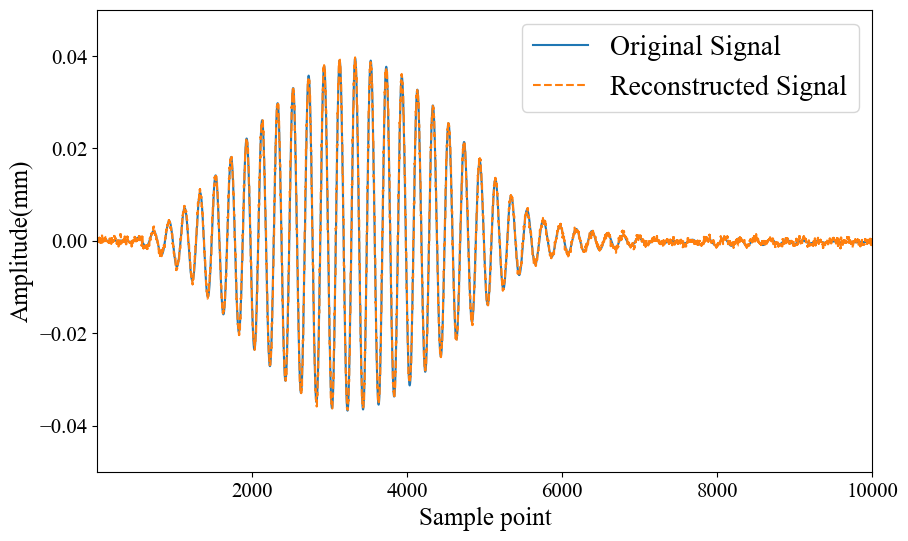

In [17]:
plt.style.use('default')
plt.figure(figsize=(10,6))
plt.rcParams['font.family'] = ['Times New Roman']
plt.plot(Original_signal,linewidth=1.5, label='Original Signal')
plt.plot(reconstructed_signal,linewidth=1.5, linestyle='--',label='Reconstructed Signal')

plt.xlabel('Sample point',fontdict={'weight': 'normal', 'size': 18})
plt.ylabel('Amplitude(mm)',fontdict={'weight': 'normal', 'size': 18})

plt.xlim([10,1e4])
plt.ylim([-0.05,0.05])
#坐标轴刻度大小设置
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc='upper right', fontsize=20)
plt.savefig(f'D:\\Desktop\\Python\\Signal_reconstruction\\Model\\PCA\\test_data_reconstruction_{n}.jpg', dpi=600, bbox_inches='tight')

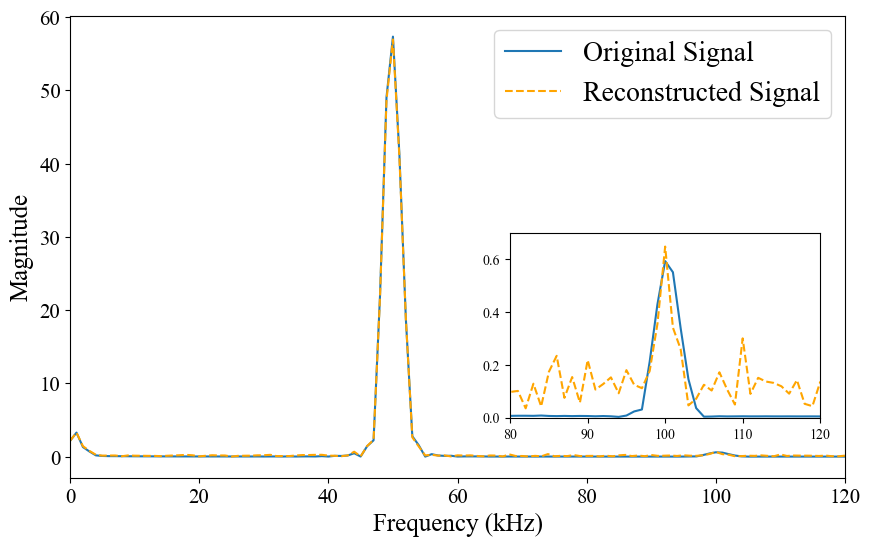

In [18]:

# 计算FFT
def calculate_fft(signal, sampling_rate):
    N = len(signal)  # 信号长度
    fft_values = np.fft.fft(signal)  # 计算FFT
    fft_magnitude = np.abs(fft_values)  # 取模
    fft_magnitude = fft_magnitude[:N // 2]  # 只取一半（正频率部分）
    freq = np.fft.fftfreq(N, d=1 / sampling_rate)[:N // 2]  # 频率轴
    return freq, fft_magnitude

# 采样率
sampling_rate = 1e7

# 假设 Original_signal 和 reconstructed_signal 已经定义
freq_origin, fft_magnitude_origin = calculate_fft(Original_signal, sampling_rate)
freq_reconstructed, fft_magnitude_reconstructed = calculate_fft(reconstructed_signal, sampling_rate)

# 绘制FFT频谱图
fig, ax = plt.subplots(figsize=(10, 6))
# 信号的FFT
ax.plot(freq_origin/1e3, fft_magnitude_origin, label='Original Signal')
ax.plot(freq_reconstructed/1e3, fft_magnitude_reconstructed, linestyle='--', label='Reconstructed Signal', color='orange')
ax.set_xlabel('Frequency (kHz)', fontdict={'weight': 'normal', 'size': 18})
ax.set_ylabel('Magnitude', fontdict={'weight': 'normal', 'size': 18})
ax.legend()
ax.set_xlim([0, 120])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(loc='upper right', fontsize=20)

# 创建局部放大图，手动指定位置
# bbox_to_anchor 是一个四元组 (x, y, width, height)，表示局部放大图的位置和大小
# bbox_transform=ax.transAxes 表示使用主图的坐标系
axins = inset_axes(ax, width="40%", height="40%", loc='lower left',
                   bbox_to_anchor=(0.55, 0.1, 1, 1), bbox_transform=ax.transAxes, borderpad=1)
axins.plot(freq_origin/1e3, fft_magnitude_origin, label='Original Signal')
axins.plot(freq_reconstructed/1e3, fft_magnitude_reconstructed, linestyle='--', label='Reconstructed Signal', color='orange')
axins.set_xlim([80, 120])
axins.set_ylim([0, 0.7])
axins.tick_params(axis='both', which='major', labelsize=10)

plt.savefig(f'D:\\Desktop\\Python\\Signal_reconstruction\\Model\\PCA\\test_reconstruction_FFT_{n}.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [19]:
fft_magnitude_reconstructed_1,fft_magnitude_origin_1 = torch.from_numpy(fft_magnitude_reconstructed),torch.from_numpy(fft_magnitude_origin)

y_loss = 1e4*loss(fft_magnitude_reconstructed_1,fft_magnitude_origin_1)

SNR=calculate_snr(fft_magnitude_reconstructed,fft_magnitude_origin)
PCC=calculate_pcc(fft_magnitude_reconstructed,fft_magnitude_origin)
print(f'Reconstruction_error:{y_loss:.4f}')
print(f'Reconstruction_SNR:{SNR:.4f}')
print(f'Reconstruction_PCC:{PCC:.4f}')

Reconstruction_error:105.6549
Reconstruction_SNR:21.9457
Reconstruction_PCC:0.9971
